# Mobile Price Classification Using Decision Tree

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
data_set = pd.read_csv("train.csv")
data_set.shape

(2000, 21)

In [3]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['price_range']

In [4]:
# Checking for missing values
missing_values = X.isnull().sum().sum()
print("Number of missing values in the dataset:",missing_values)

Number of missing values in the dataset: 0


In [5]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(1600, 20)

In [8]:
X_test.shape

(400, 20)

## Finding the Best Parameters Using Halving Grid Search

In [9]:
# Defining the parameter grid
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 40, 80],  
    'min_samples_split': [2, 4, 8],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': [None, 'sqrt', 'log2'],
}

In [10]:
halving_search = HalvingGridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                     param_grid=param_grid,
                                     cv=5,
                                     factor=3,  
                                     n_jobs=-1,
                                     verbose=3)

halving_search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 40
max_resources_: 1600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 540
n_resources: 40
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 180
n_resources: 120
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 60
n_resources: 360
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 3
n_candidates: 20
n_resources: 1080
Fitting 5 folds for each of 20 candidates, totalling 100 fits


HalvingGridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                    n_jobs=-1,
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [None, 10, 20, 40, 80],
                                'max_features': [None, 'sqrt', 'log2'],
                                'min_samples_leaf': [1, 2, 4],
                                'min_samples_split': [2, 4, 8],
                                'splitter': ['best', 'random']},
                    verbose=3)

In [11]:
# Best parameters found by HalvingGridSearchCV
print("Best parameters found:", halving_search.best_params_)

Best parameters found: {'criterion': 'gini', 'max_depth': 80, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}


### Visualizing the Results

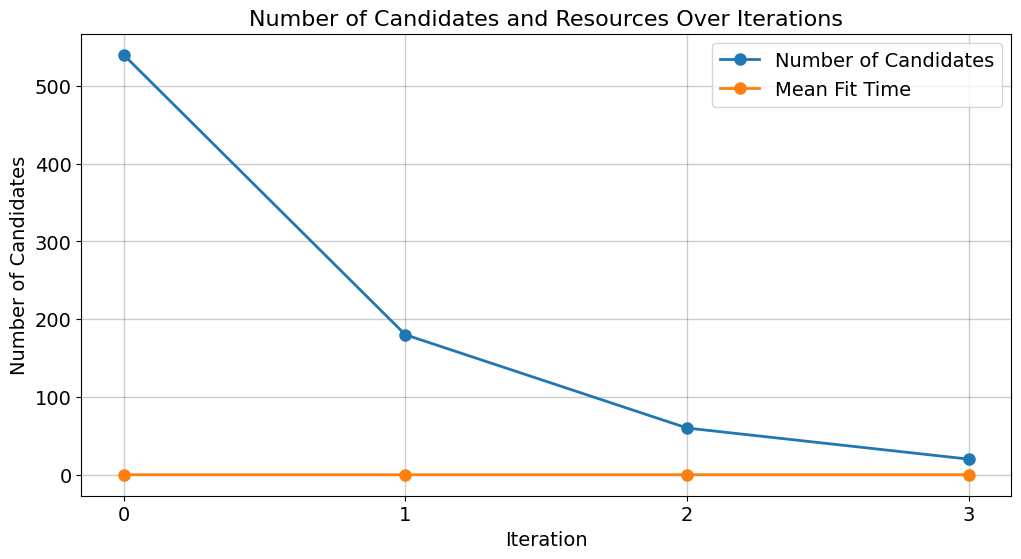

In [12]:
results = pd.DataFrame(halving_search.cv_results_)

iterations = results['iter'].values
n_candidates = results.groupby('iter').size()
mean_fit_time = results.groupby('iter')['mean_fit_time'].mean()

# Visualizing the number of candidates and resources over iterations
plt.figure(figsize=(12, 6))
plt.plot(n_candidates.index, n_candidates.values, marker='o', label='Number of Candidates', linewidth=2, markersize=8)
plt.plot(mean_fit_time.index, mean_fit_time.values, marker='o', label='Mean Fit Time', linewidth=2, markersize=8)
plt.xlabel('Iteration', color='black', fontsize=14)
plt.ylabel('Number of Candidates', color='black', fontsize=14)
plt.title('Number of Candidates and Resources Over Iterations', color='black', fontsize=16)
plt.legend(fontsize=14, ncol=1, loc="upper right")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(ticks=n_candidates.index)
plt.grid(True, linewidth=1, color='black', alpha=0.2)
plt.show()

Top 10 Parameter Combinations:
Parmeter Combination 1
{'criterion': 'gini', 'max_depth': 80, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'splitter': 'best'}

Parmeter Combination 2
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

Parmeter Combination 3
{'criterion': 'gini', 'max_depth': 80, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}

Parmeter Combination 4
{'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

Parmeter Combination 5
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

Parmeter Combination 6
{'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

Parmeter Combination 7
{'criterion': 'entropy', 'max_de

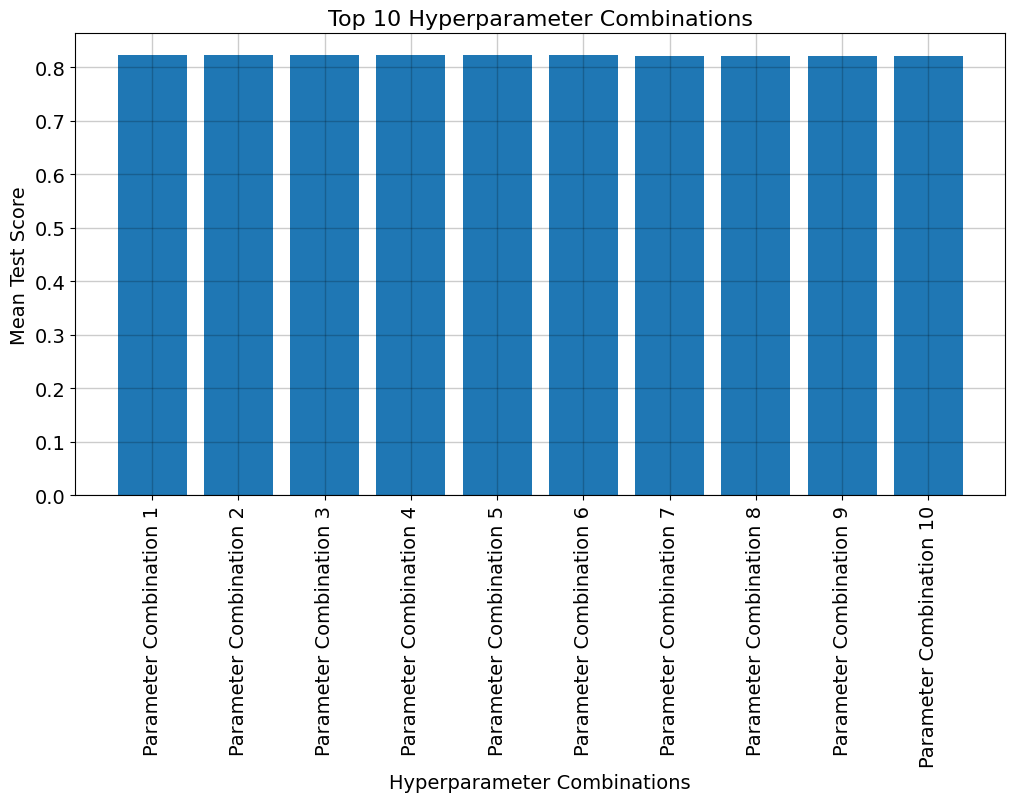

In [13]:
# Sorting by score
sorted_indices = np.argsort(results['mean_test_score'])[::-1]
sorted_scores = results['mean_test_score'].values[sorted_indices]
sorted_params = results['params'].values[sorted_indices]

top_params = [str(params) for params in sorted_params[:10]]
param_lb = []
for i in range(1,11):
    param_lb.append('Parameter Combination ' + str(i))

print('Top 10 Parameter Combinations:')
for i in range(len(top_params)):
    print('Parmeter Combination',i+1)
    print(top_params[i])
    print()

# Plotting the top 10 parameter combinations
plt.figure(figsize=(12, 6))
plt.bar(range(10), sorted_scores[:10], align='center')
plt.xticks(range(10), param_lb, rotation=90)
plt.xlabel('Hyperparameter Combinations', color='black', fontsize=14)
plt.ylabel('Mean Test Score', color='black', fontsize=14)
plt.title('Top 10 Hyperparameter Combinations', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linewidth=1, color='black', alpha=0.2)
plt.show()

## Designing the Decision Tree Model with the Optimal Hyperparameters

In [14]:
best_dt_clf = halving_search.best_estimator_

# Making predictions with the best estimator
y_train_pred = best_dt_clf.predict(X_train)
y_test_pred = best_dt_clf.predict(X_test)

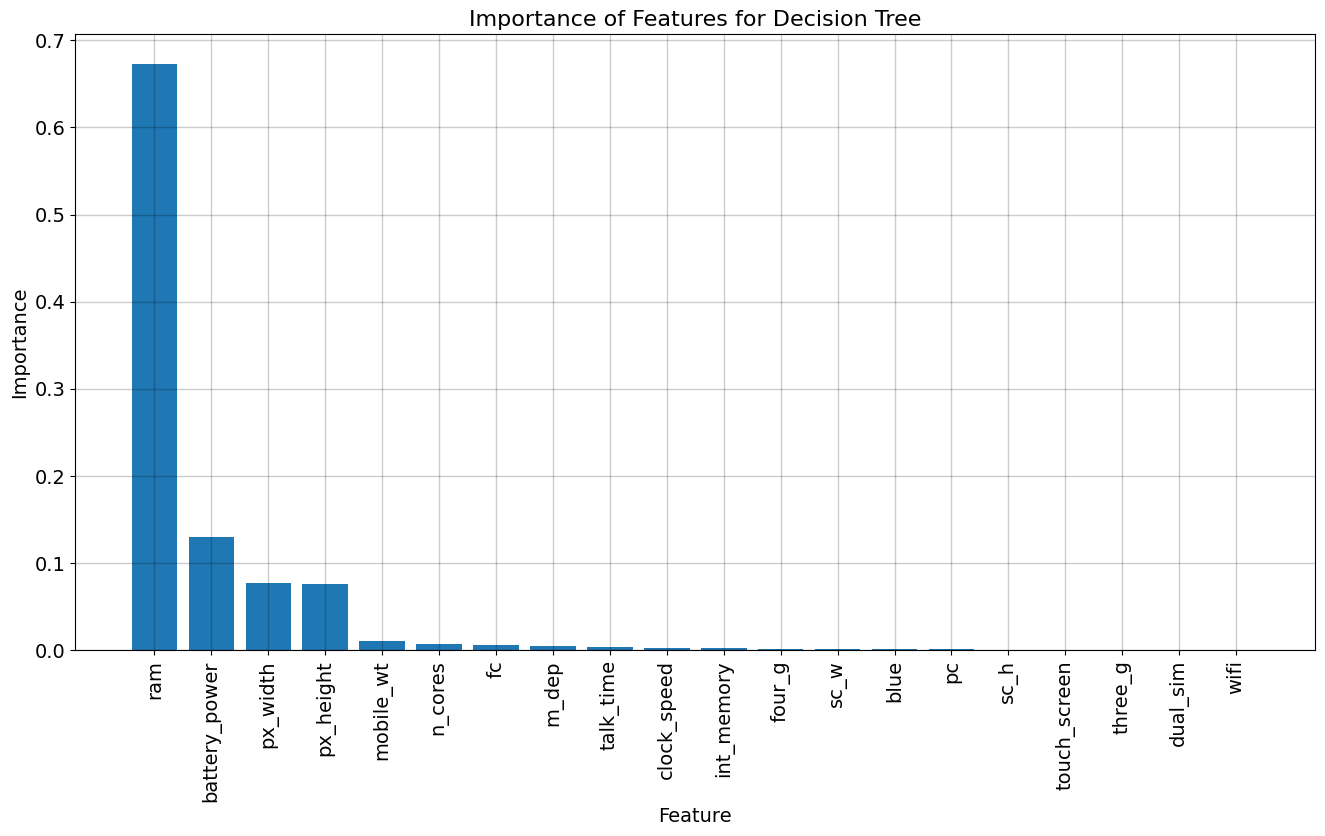

In [15]:
feature_names = data_set.columns.tolist()

# Extracting the importance of each feature
feature_importances = best_dt_clf.feature_importances_

# Indices of the features sorted by importance
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(16, 8))
plt.title('Importance of Features for Decision Tree',color='black', fontsize=16)
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlabel('Feature', color='black', fontsize=14)
plt.ylabel('Importance', color='black', fontsize=14)
plt.grid(True, linewidth=1, color='black', alpha=0.2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [16]:
# Computing the performance metrics for the training subset
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy*100,3))
print("Training Precision (in %):",round(train_precision*100,3))
print("Training Recall (in %):",round(train_recall*100,3))
print("Training F1 Score (in %):",round(train_f1*100,3))

Training Accuracy (in %): 95.0
Training Precision (in %): 95.04
Training Recall (in %): 95.0
Training F1 Score (in %): 94.989


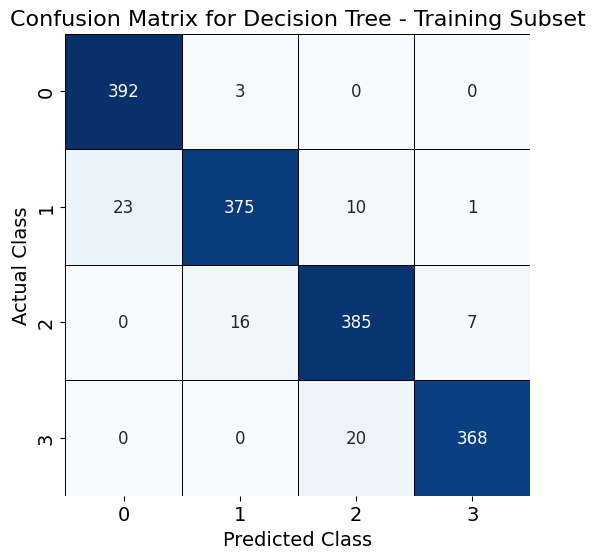

In [17]:
conf_mat_train = confusion_matrix(y_train,y_train_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_dt_clf.classes_, yticklabels=best_dt_clf.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

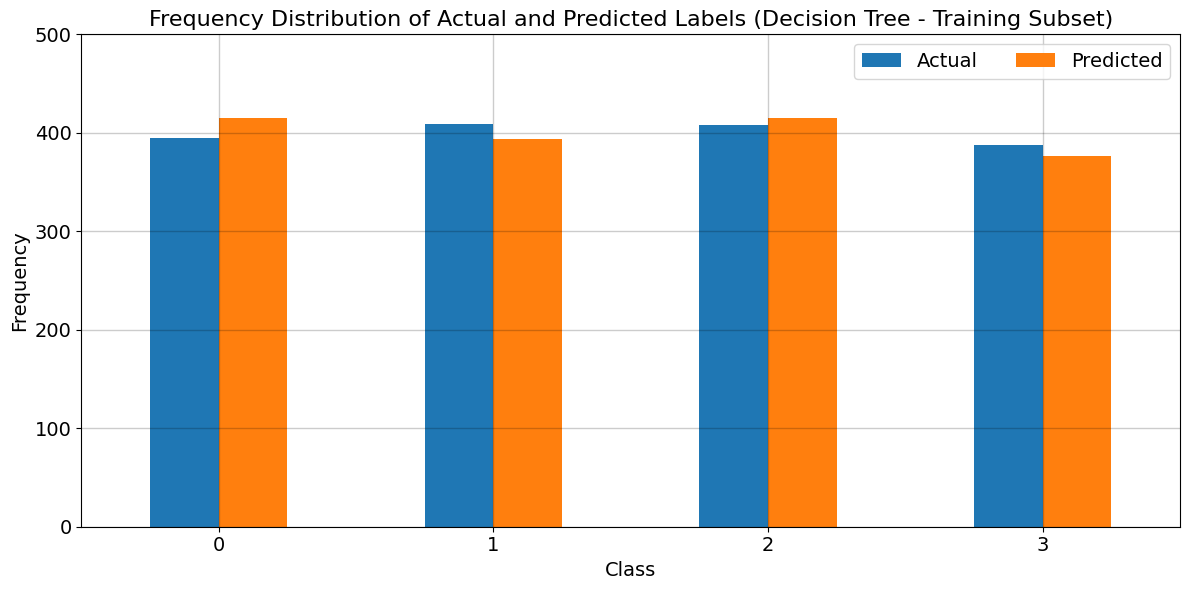

In [18]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train, predicted_counts_train = np.unique(y_train_pred, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_train)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5])
ax.set_ylim([0,500])
fig.tight_layout()
plt.show()

In [19]:
# Computing the performance metrics for the test subset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy*100,3))
print("Test Precision (in %):",round(test_precision*100,3))
print("Test Recall (in %):",round(test_recall*100,3))
print("Test F1 Score (in %):",round(test_f1*100,3))

Test Accuracy (in %): 83.25
Test Precision (in %): 83.327
Test Recall (in %): 83.25
Test F1 Score (in %): 83.263


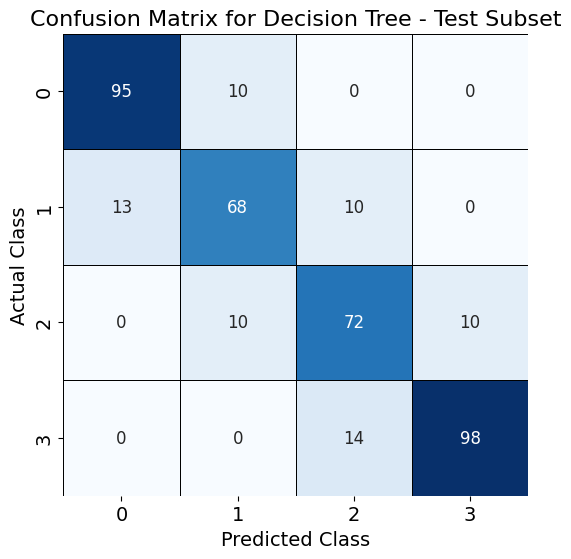

In [20]:
conf_mat_test = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_dt_clf.classes_, yticklabels=best_dt_clf.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

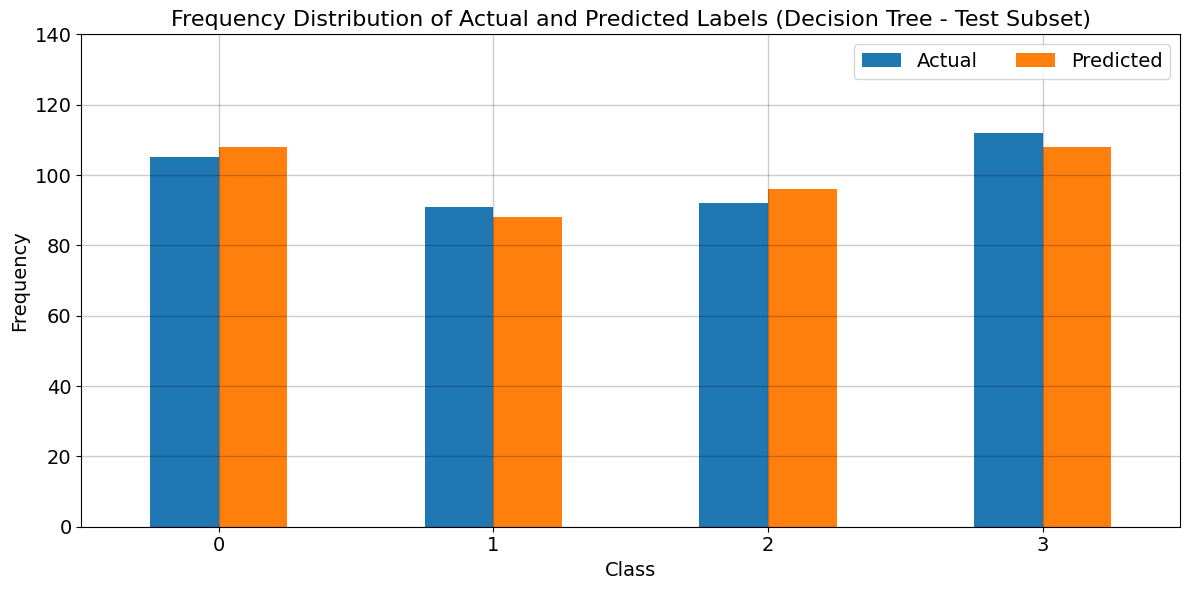

In [21]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test, predicted_counts_test = np.unique(y_test_pred, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5])
ax.set_ylim([0,140])
fig.tight_layout()
plt.show()

***